# Importing necessary library

In [ ]:
import os
import cv2
import time
import keras
import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import SGD, Adam, RMSprop, Adadelta
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten
##This code pattern demonstrates how images,specifically document images like id card,application forms,cheque leaf can be classified using CNN.
##There are code patterns for image classifications,none of them showcase how to use CNN to calssify images using keras libraries.

# Loading and processing the data

In [ ]:
##Copying and loading the data or data sets from a source file,folder or applications...

def load_and_process_data(directory):
    images = [] #empty list to hold the images
    labels = [] #empty list to hold the lables
    for root, dirs, files in os.walk(directory):
        f = os.path.basename(root)
        for file in files:
            try:
                img = cv2.imread(root+'/'+file)##read the images from the file
                img = cv2.resize(img,(300,300))##resize the images 
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)#convert an image from one colour space to another 
                img = cv2.GaussianBlur(img, (5,5), 0)#blur an image to remove noise 
                images.append(img)
                labels.append(f)
            except Exception:
                print('Error could not load all images')
    images = np.array(images)
    return (images, labels)

train_path = "/kaggle/input/horses-or-humans-dataset/horse-or-human/train"
validation_path = "/kaggle/input/horses-or-humans-dataset/horse-or-human/validation"

train_images, train_labels = load_and_process_data(train_path)
valid_images, valid_labels = load_and_process_data(validation_path)

# Visualization of the data

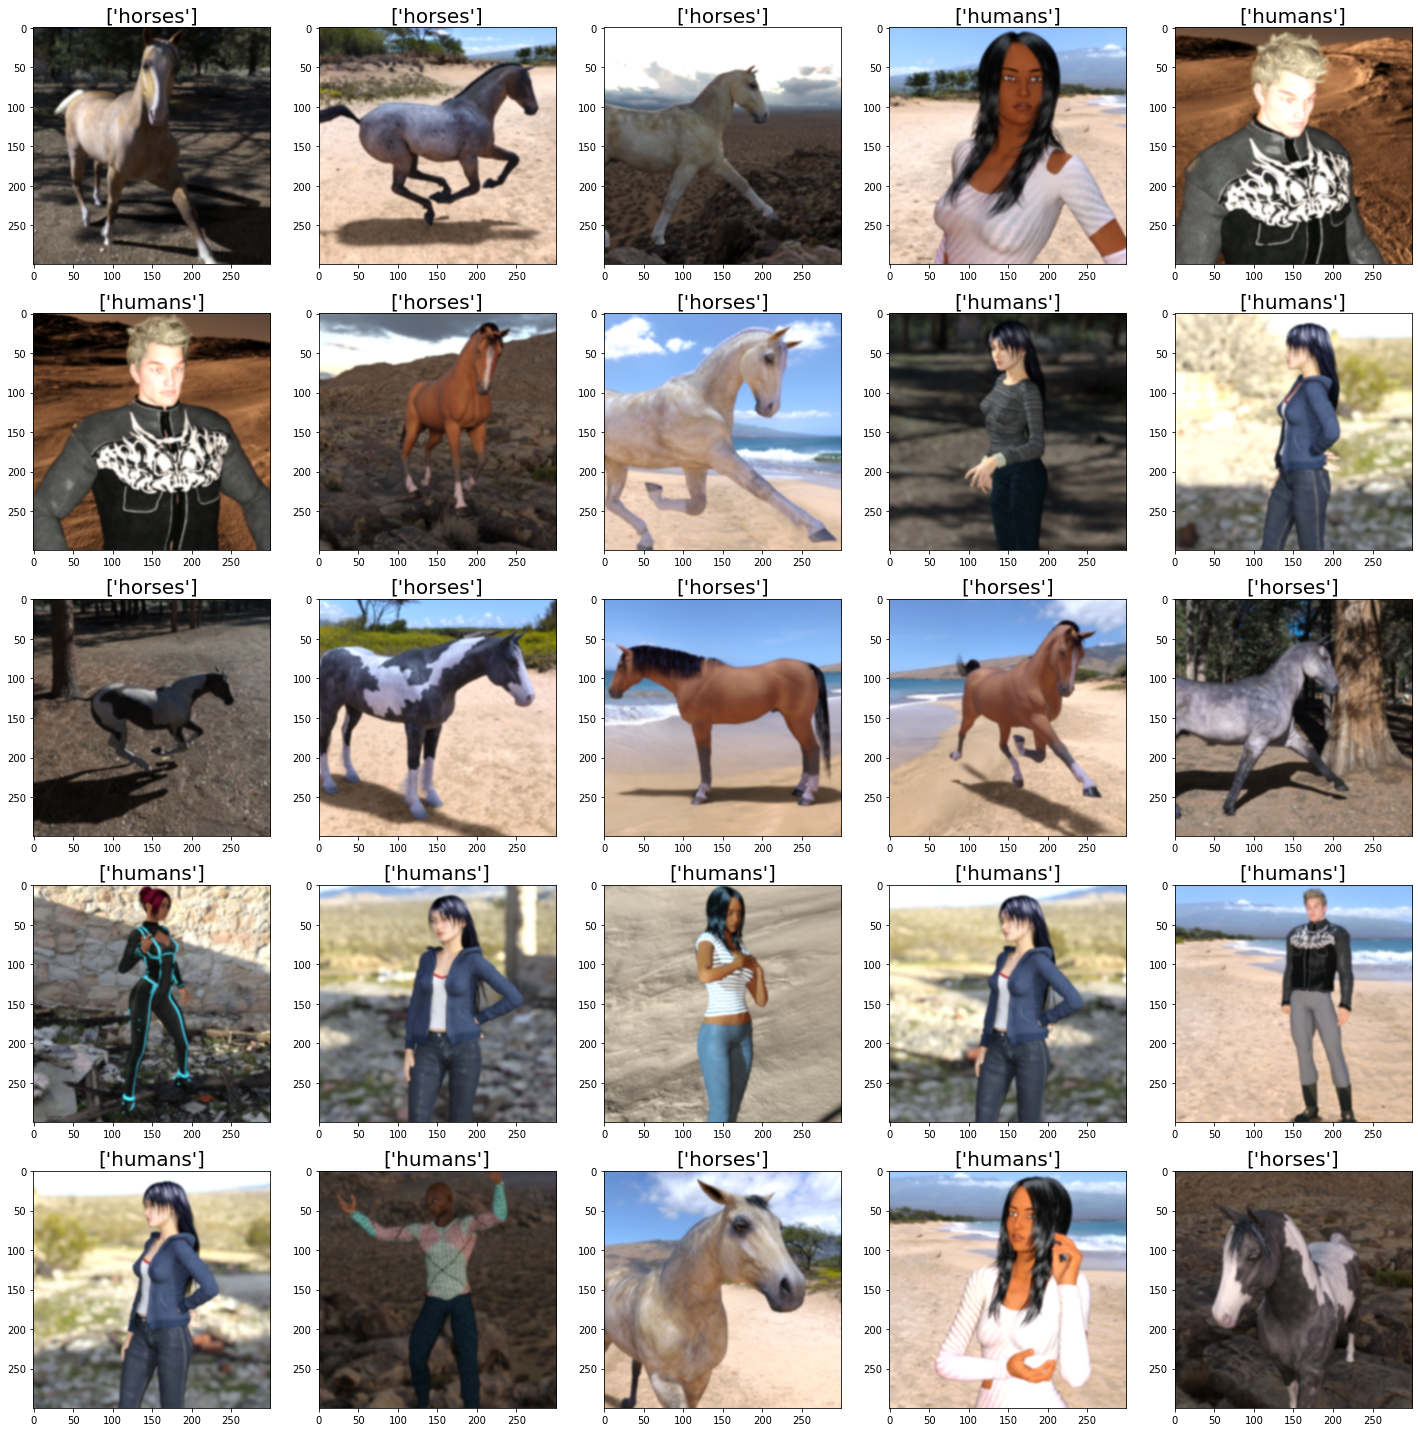

In [ ]:
fig,ax=plt.subplots(5,5)#change the figure size of more subplots
fig.set_size_inches(20,20)
for i in range(5):
    for j in range(5):
        num=np.random.randint(1,len(train_labels))
        ax[i,j].imshow(train_images[num])
        ax[i,j].set_title([train_labels[num]],size =20)
plt.tight_layout()##adjust the subpolt params so it fits in to the figure area

# Pre-Processing 

In [ ]:
def preprocess_labels(labels):
    le = LabelEncoder()#convert the label into numeric form
    labels = le.fit_transform(labels)##fit and tranform the labels
    labels = to_categorical(labels)
    labels = np.array(labels)
    labels = [int(i[0])for i in labels]
    return labels

train_labels_lst = preprocess_labels(train_labels)
valid_labels_lst = preprocess_labels(valid_labels)

# Train Test Split
train_images,test_images,train_labels_lst,test_labels_lst = train_test_split(train_images,train_labels_lst,test_size=0.25,random_state=20)


train_images = train_images / 255.0# Normalize Images
test_images = test_images / 255.0# Normalize Images
valid_images = valid_images / 255.0# Normalize Images
train_images.shape, test_images.shape, valid_images.shape

((770, 300, 300, 3), (257, 300, 300, 3), (256, 300, 300, 3))

# Data Augmentation

In [ ]:
batch_size = 30
#tain data augmentation
###ImageDataGenerator class allows you to randomly rotate images through any degree between O and 1
train_data_aug = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

test_datagen = keras.preprocessing.image.ImageDataGenerator()
val_datagen = keras.preprocessing.image.ImageDataGenerator()

train_gen = train_data_aug.flow(train_images, train_labels_lst, batch_size=batch_size)
test_gen = test_datagen.flow(test_images, test_labels_lst, batch_size=batch_size)#Number of samples per batch of computation
valid_gen = val_datagen.flow(valid_images, valid_labels_lst, batch_size=batch_size,shuffle=False)
#The diirectory is set where n classes of folder are present
#the target_size is the size of input images ,every image will be resized to this size.
##train and test the images 

# Custom CNN model

In [ ]:

cnn_model = keras.models.Sequential()
cnn_model.add(Conv2D(128, (3,3), activation='relu',input_shape=(300,300,3))) #--> 
cnn_model.add(MaxPooling2D(3,3))
#Determines the number of kernels to convolve with the input volume
#This layer creates a convulation kernelthat is convolved with the layer input to produce a tensor of outputs.
cnn_model.add(Conv2D(256, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(2,2))
#Maxpooling operaion for 2D spatial data
#ouput_shape=math.floor((input_shape-pool_size)/strides)+1(when input_shape >= pool_size)

cnn_model.add(Conv2D(256, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(Conv2D(512, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(Conv2D(1028, (3,3), activation='relu'))
#Relu is linear functiong that will ouput the input directly it it is positive othwrwise it will be zero.
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(Flatten())
cnn_model.add(BatchNormalization())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.30))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
#sigmoid is used in order to map predicted values to probabilities.
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 256)       590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 512)       1

#  Model compilation

In [ ]:
# Compile Model
cnn_model.compile(optimizer=Adadelta(lr=0.0001),loss='binary_crossentropy',metrics=['acc'])
##An optimizer is one the two arguments required for compiling a keras model
### pass optimizer by name: default parameters will be used

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

cb = EarlyStopping(monitor='val_loss', min_delta=0.02, patience=3, restore_best_weights=True)

history = cnn_model.fit(train_gen,epochs=5,validation_data=test_gen, callbacks=[cb])

Epoch 1/5
26/26 [==============================] - 286s 11s/step - loss: 0.6933 - acc: 0.5028 - val_loss: 0.6932 - val_acc: 0.4591
Epoch 2/5
26/26 [==============================] - 278s 11s/step - loss: 0.6898 - acc: 0.5043 - val_loss: 0.6932 - val_acc: 0.5058
Epoch 3/5
26/26 [==============================] - 285s 11s/step - loss: 0.6900 - acc: 0.5513 - val_loss: 0.6931 - val_acc: 0.5175
Epoch 4/5
26/26 [==============================] - 278s 11s/step - loss: 0.6870 - acc: 0.5458 - val_loss: 0.6930 - val_acc: 0.5447


# Ploting Model loss

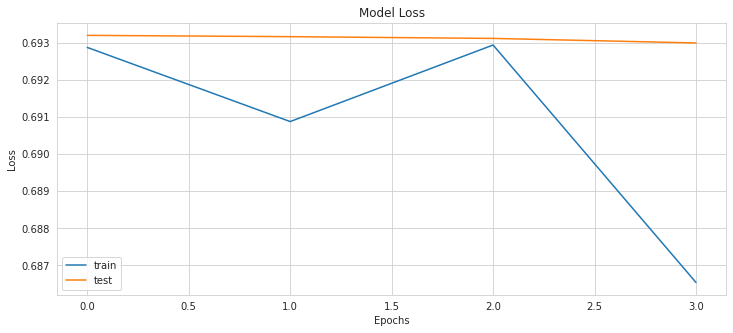

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

# Ploting Model accuracy

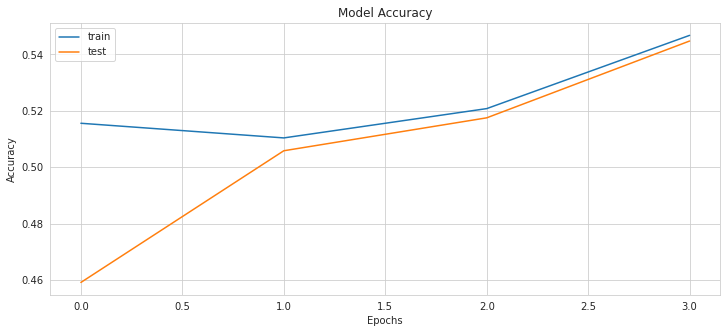

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
# Train data evaluation
train_score = cnn_model.evaluate(train_gen)
# Test data evaluation
test_score = cnn_model.evaluate(test_gen)
# Validation data evaluation
valid_score = cnn_model.evaluate(valid_gen)

9/9 [==============================] - 25s 3s/step - loss: 0.6932 - acc: 0.5156


In [ ]:
print("Train_Accuracy = ",train_score[1])
print("Test_Accuracy = ",test_score[1])
print("Validation_Accuracy = ",valid_score[1])
#print the train,Test and Validation accuracy

Train_Accuracy =  0.4935064911842346
Test_Accuracy =  0.4591439664363861
Validation_Accuracy =  0.515625
